In [ ]:
!unzip /content/data.zip

In [ ]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
torch.__version__

'2.9.0+cu126'

In [ ]:
import torch.nn as nn

# Create a simple neural network class
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, num_classes=1): # num_classes should be 1 for binary classification
        super(SimpleNeuralNetwork, self).__init__()  # Initialize superclass to set up modules
        # Define the layers:
        # Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        # Calculate the size of the flattened layer after conv and pooling
        # Input size: (3, 200, 200)
        # After conv1: (32, 200-3+1, 200-3+1) = (32, 198, 198)
        # After pool1: (32, 198/2, 198/2) = (32, 99, 99)
        self.flatten = nn.Flatten()

        # Linear layers
        self.linear1 = nn.Linear(32 * 99 * 99, 64) # First linear layer with 64 neurons
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, num_classes) # Output layer with 1 neuron for binary classification


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x


# # Demonstrate our model with an example tensor
# # The input tensor for a CNN should typically be (batch_size, channels, height, width)
# example_tensor = torch.rand(32, 3, 200, 200)  # Batch of 5 samples, each a 3-channel (RGB) 200x200 image
# print("Input Tensor Size:", example_tensor.size())

# # Instantiate the model and pass the example tensor
# model = SimpleNeuralNetwork()
# output = model(example_tensor)
# print("Output Tensor Size:", output.size())

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleNeuralNetwork(num_classes=1)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Option 1: Using torchsummary (install with: pip install torchsummary)
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

# Option 2: Manual counting
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters: {total_params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
           Flatten-4               [-1, 313632]               0
            Linear-5                   [-1, 64]      20,072,512
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 23.93
Params size (MB): 76.57
Estimated Total Size (MB): 100.96
----------------------------------------------------------------


In [ ]:
from torchvision import transforms

input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # ImageNet normalization
])

val_transforms = train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std) # ImageNet normalization
])

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torch.utils.data import DataLoader

train_dataset = ClothingDataset(
    data_dir='/content/data/train',
    transform=train_transforms
)

validation_dataset = ClothingDataset(
    data_dir='/content/data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [ ]:
len(train_loader)

41

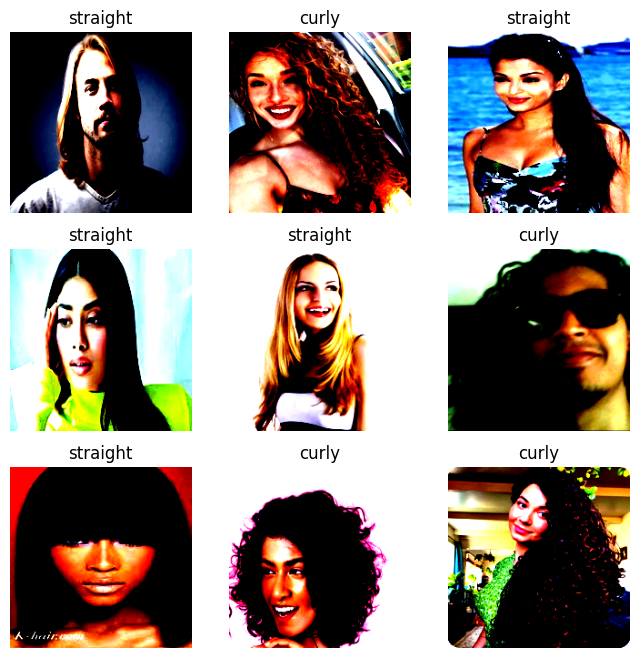

In [ ]:
import matplotlib.pyplot as plt
classes = sorted(os.listdir('/content/data/train'))
class_to_idx = {cls: i for i, cls in enumerate(classes)}

# Set up a plot for 9 random images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label]) # Fixed line: Use classes list with label as index
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)) # Fixed: Permute dimensions for matplotlib
plt.show()

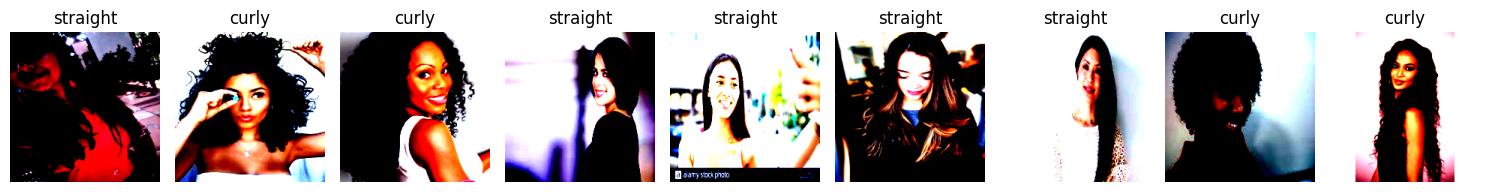

In [ ]:
import matplotlib.pyplot as plt

# Retrieve one batch of images and labels
images, labels = next(iter(train_loader))

# Let's plot up to 9 images from the batch for better visualization
num_images_to_plot = min(len(images), 9) # Plot up to 9 images

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3)) # Adjust figsize for better display
if num_images_to_plot == 1:
    axes = [axes] # Ensure axes is iterable if only one image is plotted

for i in range(num_images_to_plot):
    img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

    # The images are normalized, so matplotlib might clip values outside [0,1].
    # For accurate display, denormalization can be performed:
    # mean_tensor = torch.tensor(mean).view(3, 1, 1)
    # std_tensor = torch.tensor(std).view(3, 1, 1)
    # img = img * std_tensor + mean_tensor
    # img = img.clamp(0, 1)

    axes[i].imshow(img)
    # Get the class name using the label from the batch
    axes[i].set_title(train_dataset.classes[labels[i]])
    axes[i].axis("off")
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

In [ ]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.0076, Acc: 1.0000, Val Loss: 0.9329, Val Acc: 0.7463
Epoch 2/10, Loss: 0.0061, Acc: 1.0000, Val Loss: 0.9923, Val Acc: 0.7363
Epoch 3/10, Loss: 0.0113, Acc: 0.9975, Val Loss: 0.9959, Val Acc: 0.7562
Epoch 4/10, Loss: 0.0044, Acc: 1.0000, Val Loss: 1.0019, Val Acc: 0.7562
Epoch 5/10, Loss: 0.0037, Acc: 1.0000, Val Loss: 1.0370, Val Acc: 0.7512
Epoch 6/10, Loss: 0.0033, Acc: 1.0000, Val Loss: 1.0169, Val Acc: 0.7512
Epoch 7/10, Loss: 0.0029, Acc: 1.0000, Val Loss: 1.0355, Val Acc: 0.7512
Epoch 8/10, Loss: 0.0026, Acc: 1.0000, Val Loss: 1.0741, Val Acc: 0.7512
Epoch 9/10, Loss: 0.0023, Acc: 1.0000, Val Loss: 1.0568, Val Acc: 0.7512
Epoch 10/10, Loss: 0.0021, Acc: 1.0000, Val Loss: 1.0916, Val Acc: 0.7562


In [ ]:
import numpy as np

median_of_training_accuracy = history['acc']
median_training_accuracy = np.median(median_of_training_accuracy)
print(f"Median of training accuracy: {median_training_accuracy:.4f}")

Median of training accuracy: 0.6660


In [ ]:
import numpy as np

std_of_training_loss = history['loss']
std_training_loss = np.std(std_of_training_loss)
print(f"Standard deviation of training loss: {std_training_loss:.4f}")

Standard deviation of training loss: 0.0694


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [ ]:
train_augmentation_dataset = ClothingDataset(
    data_dir='/content/data/train',
    transform=train_transforms
)

train_loader = DataLoader(
    train_augmentation_dataset,
    batch_size=20,
    shuffle=True
)

In [ ]:
len(train_loader)

41

In [ ]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.7897, Acc: 0.6280, Val Loss: 0.5871, Val Acc: 0.7264
Epoch 2/10, Loss: 0.6356, Acc: 0.6542, Val Loss: 0.6002, Val Acc: 0.7114
Epoch 3/10, Loss: 0.5918, Acc: 0.6517, Val Loss: 0.5897, Val Acc: 0.6766
Epoch 4/10, Loss: 0.6385, Acc: 0.6255, Val Loss: 0.5914, Val Acc: 0.7214
Epoch 5/10, Loss: 0.6015, Acc: 0.6717, Val Loss: 0.5747, Val Acc: 0.7164
Epoch 6/10, Loss: 0.5553, Acc: 0.7203, Val Loss: 0.5423, Val Acc: 0.7761
Epoch 7/10, Loss: 0.5414, Acc: 0.7191, Val Loss: 0.8177, Val Acc: 0.6269
Epoch 8/10, Loss: 0.5469, Acc: 0.6829, Val Loss: 0.5627, Val Acc: 0.7512
Epoch 9/10, Loss: 0.6126, Acc: 0.6604, Val Loss: 0.7034, Val Acc: 0.5920
Epoch 10/10, Loss: 0.5614, Acc: 0.7029, Val Loss: 0.6783, Val Acc: 0.7015


In [ ]:
mean_of_test_loss = history['val_loss']
mean_test_loss = np.mean(mean_of_test_loss)
print(f"Median of training accuracy: {mean_test_loss:.4f}")

Median of training accuracy: 0.6248


In [ ]:
avg_of_test_accuracy = history['val_acc']
avg_test_accuracy = np.mean(avg_of_test_accuracy)
print(f"Median of training accuracy: {avg_test_accuracy:.4f}")

Median of training accuracy: 0.7000


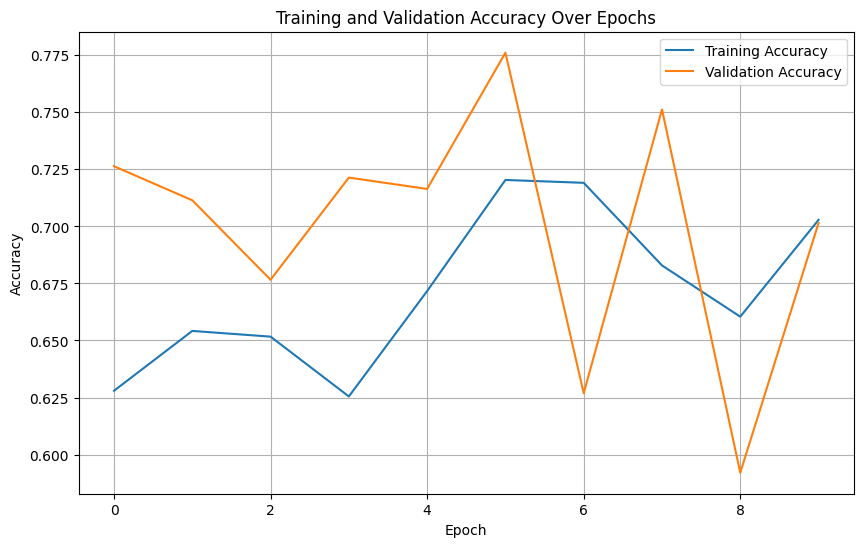

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()